In [1]:
import sys
from pathlib import Path

# Add the project root (one level up from notebooks/) to sys.path
sys.path.append(str(Path().resolve().parent))

import importlib
from spine_score.src import extract, dataset, model
from pathlib import Path
import os 
import zipfile
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import glob
import torch

from spine_score.src.model import SimpleUNet3D, train_model, evaluate_model, print_metrics

In [2]:
# Reloads modules (run for development update with the notebook)
importlib.reload(extract) 
importlib.reload(dataset)
importlib.reload(model)

<module 'spine_score.src.model' from 'C:\\Users\\Maxtw\\OneDrive\\Desktop\\Final Project 521\\aai-521-final-project\\spine_score\\src\\model.py'>

In [3]:
# Matching Study Ids to ensure that segmentation and images are mapped appropriately 
# DICOM root after extraction
dicom_root = "../data/interim/imaging_files/case_image"

# Segmentation root
mask_root = "../data/interim/segmentation"

# Map study_id -> DICOM folder
dicom_map = {}
for folder in glob.glob(os.path.join(dicom_root, "*")):  # first level
    study_id = os.path.basename(folder)
    # pick the deepest folder containing DICOMs
    dcm_subfolders = [f for f in glob.glob(os.path.join(folder, "**"), recursive=True) if os.path.isdir(f) and len(glob.glob(os.path.join(f, "*.dcm"))) > 0]
    if dcm_subfolders:
        dicom_map[study_id] = dcm_subfolders[0]
        
# Map study_id -> mask file
mask_map = {}
for mask_file in glob.glob(os.path.join(mask_root, "*_SEG.nii.gz")):
    study_id = os.path.basename(mask_file).split("_")[0]
    mask_map[study_id] = mask_file

# Only keep the studies that have both DICOMs and masks
dataset_entries = [(dicom_map[s], mask_map[s]) for s in dicom_map if s in mask_map]

print(f"Found {len(dataset_entries)} paired DICOMs and masks")
print(f"Example entry: {dataset_entries[0]}")

Found 1232 paired DICOMs and masks
Example entry: ('../data/interim/imaging_files/case_image\\593973-000001\\1.2.826.0.1.3680043.10.474.593973.2\\1.2.826.0.1.3680043.10.474.593973.3', '../data/interim/segmentation\\593973-000001_Study-MR-1_Series-22_SEG.nii.gz')


In [4]:
from sklearn.model_selection import train_test_split

# dataset_entries already built earlier
print("Total samples:", len(dataset_entries))

# First split: train + temp (val+test)
train_entries, temp_entries = train_test_split(
    dataset_entries, test_size=0.3, random_state=42
)

# Second split: val + test
val_entries, test_entries = train_test_split(
    temp_entries, test_size=0.5, random_state=42
)

print(f"Train 70%: {len(train_entries)}")
print(f"Val 15%:   {len(val_entries)}")
print(f"Test 15%:  {len(test_entries)}")


Total samples: 1232
Train 70%: 862
Val 15%:   185
Test 15%:  185


In [5]:
target_shape = (1, 224, 224, 48)  # divisible by 16 (if UNet has 4 downsamplings)
target_spacing=(1.0, 1.0, 1.0)

# Creating a dataset objects that knows how to load DICOM volumes + NIfTI masks one sample at a time
train_dataset = dataset.SpineSegDataset(train_entries, target_shape=target_shape, target_spacing=target_spacing)
val_dataset   = dataset.SpineSegDataset(val_entries, target_shape=target_shape, target_spacing=target_spacing)
test_dataset  = dataset.SpineSegDataset(test_entries, target_shape=target_shape, target_spacing=target_spacing)

# Wraps dataset into an iterable loader that handles batching + shuffling
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_dataset,  batch_size=2, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

In [29]:
import torch
from spine_score.src.model import SimpleUNet3D

device = "cuda" if torch.cuda.is_available() else "cpu"

# Recreate the architecture
model_UNet = SimpleUNet3D(in_channels=1, out_channels=3)

# Load saved weights
state_dict = torch.load("best_model.pth", map_location=device)
#state_dict = torch.load("best_model.pth", map_location=device)
model_UNet.load_state_dict(state_dict)

# Move to device and set to eval mode
model_UNet.to(device)
model_UNet.eval()


SimpleUNet3D(
  (encoder): ModuleList(
    (0): DoubleConv(
      (double_conv): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(in

Slices with foreground: tensor([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34])
Using slice: 26


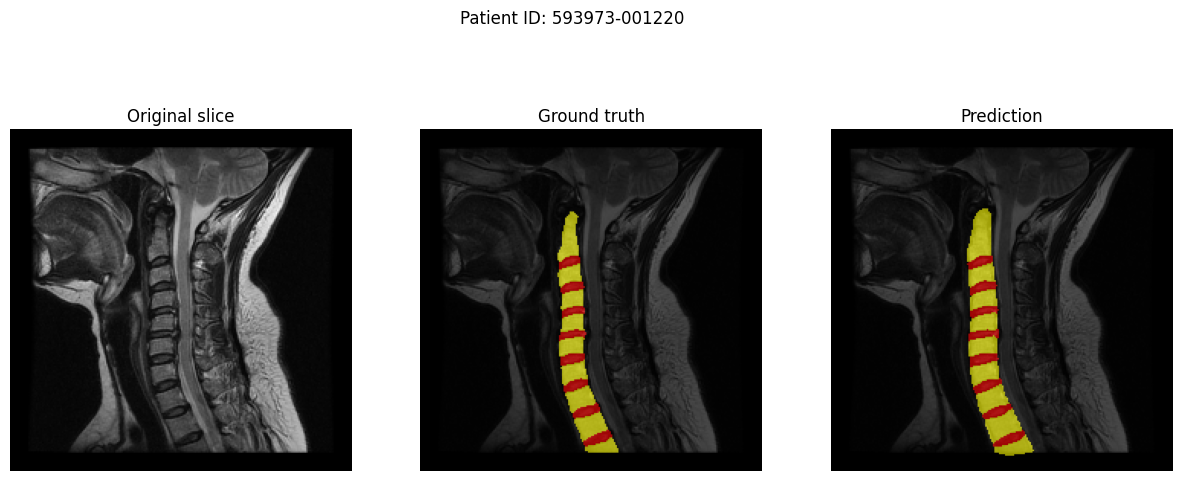

In [32]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

model_UNet.load_state_dict(torch.load("best_model.pth"))
model_UNet.eval()

cmap = ListedColormap(["black", "yellow", "red"])  # background, class1, class2

# Get one batch
vol, msk, patient_id = next(iter(test_loader))
vol = vol.to(device)

# Run model
with torch.no_grad():
    logits = model_UNet(vol)                        # (B,C,H,W,D)
    probs = torch.softmax(logits, dim=1)            # FIXED
    pred_labels = torch.argmax(probs, dim=1)        # (B,H,W,D)

# Extract data
pred_mask = pred_labels[0].cpu()
true_mask = msk[0]
image = vol[0,0].cpu()

slices_with_fg = torch.where(true_mask.sum(dim=(0,1)) > 0)[0]
print("Slices with foreground:", slices_with_fg[:20])
mid = int(slices_with_fg[len(slices_with_fg)//2])
print("Using slice:", mid)


plt.figure(figsize=(15,6))

# Original slice
plt.subplot(1,3,1)
plt.title("Original slice")
plt.imshow(image[:,:,mid], cmap="gray")
plt.axis("off")

# Ground truth
plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(image[:,:,mid], cmap="gray")
plt.imshow(true_mask[:,:,mid], cmap=cmap, alpha=0.6, vmin=0, vmax=2)
plt.axis("off")

# Prediction
plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(image[:,:,mid], cmap="gray")
plt.imshow(pred_mask[:,:,mid], cmap=cmap, alpha=0.6, vmin=0, vmax=2)
plt.axis("off")

plt.suptitle(f"Patient ID: {patient_id[0]}")
plt.show()


In [ ]:
state = torch.load("best_model.pth")
print(len(state.keys()))


106


In [9]:
print(next(model_UNet.parameters()).device)


cuda:0


In [10]:
print("Unique predicted labels:", pred_mask.unique())


Unique predicted labels: tensor([0, 1, 2])


In [11]:
with torch.no_grad():
    test_logits = model_UNet(vol)
print("logits mean:", test_logits.mean().item())
print("logits std:", test_logits.std().item())


logits mean: -0.06423082947731018
logits std: 0.1279316246509552
